# Case Study 4 : Data Science in Any Data You Like

**Required Readings:** 
* In this case study, you could use any data as you like.
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


**NOTE**
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.


# Problem: pick a data science problem that you plan to solve using your Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

<p style="color:Dark blue;line-height:1.3em;font-size:1.3em;">
We are in the middle of a pandemic, United States went through one of the most rudimentary process, the Presidential elections. Americans have voted in the 2020 presidential election at their highest rate in 120 years. 

<p style="color:Dark blue;line-height:1.3em;font-size:1.3em;">
Voting at such a time has its own challenges. We are looking to work on a problem that is very recent and has had a significant impact on our lives this year. In our problem we will be analyzing the COVID-19 dataset and the results of the Presidential elections 2020 to see if there is any interplay between them.</p><br>


























# Data Collection/Processing: 

<p style="color:Dark blue;line-height:1.3em;font-size:1.3em;">
   For the first dataset, we chose the Johns Hopkins University's COVID-19 dataset which lists the number of people infected across USA by each county and hence by state.

<p style="color:Dark blue;line-height:1.3em;font-size:1.3em;">
For the second dataset, we found the election dataset that listed voter information by county and the respective candidates chosen by the people of each county </p><br>

In [1]:
import numpy as np
import pandas as pd

covid = pd.read_csv('covid.csv') # from John Hopkins University
#covid = covid.drop(['fips'], axis=1)
covid['date'] = pd.to_datetime(covid['date'])
election = pd.read_csv('election.csv') # from election Desk HK

In [2]:
from urllib.request import urlopen
import json
import plotly.express as px
import us
import shapefile
from IPython.display import IFrame
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [3]:
import seaborn as sns
sns.set_style('ticks', {"xtick.major.size": 1, "ytick.major.size": 1}) #customized the plot

In [4]:
def getCovidDataByMonth(data, month):
    pdFilter = data['date'].map(lambda x: x.month) == month
    response = data[pdFilter].reset_index()
    response = response.drop(['index'], axis=1)
    return response

def getCovidDataByState(data, state):
    pdFilter = data["state"] == state
    response = data[pdFilter].reset_index()
    response = response.drop(['index'], axis=1)
    return response

def getCovidDataByCounty(data, county, state):
    pdFilter = (data["county"] == county) & (data["state"] == state)
    response = data[pdFilter].reset_index()
    response = response.drop(['index'], axis=1)
    return response

def sumCovidDataByCounty(data, label = "cases"):
    response = data.groupby(['county', 'state']).last()
    response = response.sort_values(by=label, ascending=False)
    response = response.drop(['date'], axis=1)
    response = response.reset_index()
    pdFilter = (response.index.map(lambda x: response["county"][x]) != "Unknown")
    response = response[pdFilter]
    return response

def compareSumedCovidDataByCounty(data1, data2, label = "cases"):
    response = pd.merge(data1, data2, left_on=['county', 'state'], right_on=['county', 'state'])
    merged = (response[label + "_y"] / response[label + "_x"] * 100) - 100
    response["increase"] = merged
    pdFilter = (response.index.map(lambda x: response["cases_x"][x]) >= 1000)
    response = response[pdFilter]
    response = response.sort_values(by="increase", ascending=False)
    return response

def getVoteByCounty(data, county, state):
    pdFilter = (data["county"] == county + " County") & (data["state"] == state)
    response = data[pdFilter].reset_index()
    response = response.drop(['index'], axis=1)
    if len(response) > 1:
        dem = [response[response["party"] == "DEM"].iloc[0]["total_votes"]]
        rep = [response[response["party"] == "REP"].iloc[0]["total_votes"]]
        frame = {"DEM": dem, "REP": rep, "DEM_perc": [dem[0] * 100 / (dem[0] + rep[0])], "REP_perc": [rep[0] * 100 / (dem[0] + rep[0])]}
        response = pd.DataFrame (frame, columns = ['DEM',"REP","DEM_perc","REP_perc"])
    return response

def read_shapefile(sf_shape): 
    fields = [x[0] for x in sf_shape.fields][1:]
    records = [y[:] for y in sf_shape.records()]
    shps = [s.points for s in sf_shape.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df
shapefile_path = './shapefile2/tl_2019_us_county.shp'
us_shape = shapefile.Reader(shapefile_path)
us_data = read_shapefile(us_shape)
state = []
for statefp in us_data.STATEFP:
    state.append(str(us.states.lookup(statefp)))
us_data['state'] = state


def addVoteToCovidData(covid, election):
    response = covid.copy()
    dem = []
    rep = []
    dem_perc = []
    rep_perc = []
    for ind in covid.index:
        temp = getVoteByCounty(election, response["county"][ind], response["state"][ind])
        if len(temp) > 0:
            dem.append(temp.iloc[0]["DEM"])
            rep.append(temp.iloc[0]["REP"])
            dem_perc.append(temp.iloc[0]["DEM_perc"])
            rep_perc.append(temp.iloc[0]["REP_perc"])
        else:
            dem.append(0)
            rep.append(0)
            dem_perc.append(0)
            rep_perc.append(0)
    response["DEM"] = dem
    response["REP"] = rep
    response["DEM_perc"] = dem_perc
    response["REP_perc"] = rep_perc
    return response

def drawMap(data,location_field_name,intensity_field_name,label, html_export_location,max_value = 100,min_value = 0, color_scale = 'Emrld'):
    fig = px.choropleth(data, geojson=counties, locations=location_field_name, color=intensity_field_name,
                           color_continuous_scale=color_scale,
                           range_color=(min_value, max_value),
                           scope="usa",
                           labels={intensity_field_name:label}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html(html_export_location)
def addFips(data,state_field_name,county_field_name,ref=us_data):
    fips = []
    i = 0
    for s, c in zip(data[state_field_name], data[county_field_name]):
        x = ref.loc[(ref['state']==s) & ((ref['NAMELSAD'] == c) | (ref['NAME'] == c)), ['GEOID']].to_string(header=False,index=False).replace(' ','')
    if 'Empty' in x:
        fips.append('00000')
    else:
        fips.append(x)
    data['fips'] = fips
    return data
def fixFips(data):
    data['fips'] = data.fips.astype(str)
    data['fips'] = data.fips.apply(lambda S:S.strip('.0'))
    data['fips'] = data.fips.map(lambda x: str(x).zfill(5))
    return data

In [5]:
covid_count = pd.read_csv("covid.csv")
covid_count.drop(covid_count.index[covid_count['county'] == 'Unknown'], inplace = True)

In [6]:
cond = covid_count['county'] == 'New York City'
covid_count['fips'] = covid_count['fips'].fillna(cond.map({True: 36061}))
cond = covid_count['county'] == 'Kansas City'
covid_count['fips'] = covid_count['fips'].fillna(cond.map({True: 20000}))
cond = covid_count['county'] == 'Joplin'
covid_count['fips'] = covid_count['fips'].fillna(cond.map({True: 29000}))

In [7]:
covid_count['date'] = pd.to_datetime(covid_count['date'])
covid_count['Weekday'] =covid_count['date'].dt.day_name()
covid_count['month'] =covid_count['date'].dt.month
covid_count['month_name'] = pd.to_datetime(covid_count['month'], format='%m').dt.month_name().str.slice(stop=3)

# Data Exploration: Exploring your data

**plot some properties/statistics/distribution of your data** 

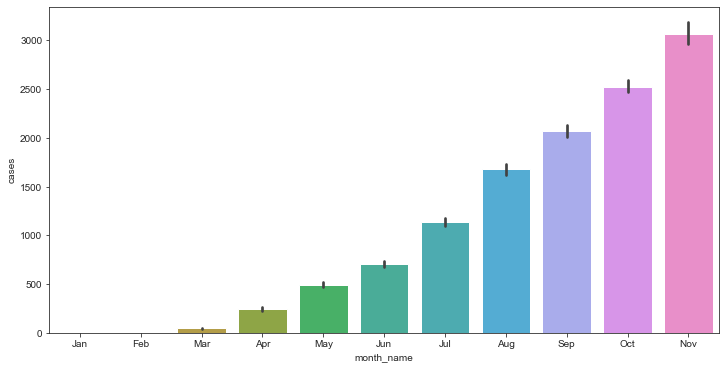

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
ax = sns.barplot(x="month_name", y="cases", data=covid_count)

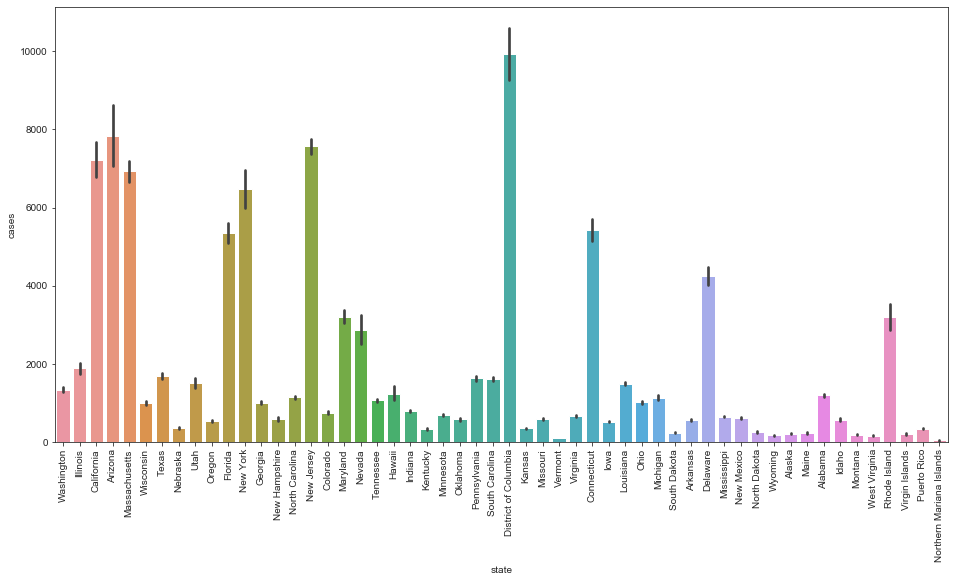

In [9]:
plt.figure(figsize=(16,8))
g =sns.barplot(x="state", y="cases",
              data=covid_count);
plt.xticks(rotation = 90)
plt.show()

In [10]:
september = getCovidDataByMonth(covid, 9)
october = getCovidDataByMonth(covid, 10)

In [11]:
september

,date,county,state,fips,cases,deaths
0,2020-09-01,Autauga,Alabama,1001.0,1453,24
1,2020-09-01,Baldwin,Alabama,1003.0,4568,42
2,2020-09-01,Barbour,Alabama,1005.0,764,7
3,2020-09-01,Bibb,Alabama,1007.0,558,8
4,2020-09-01,Blount,Alabama,1009.0,1303,11
...,...,...,...,...,...,...
97101,2020-09-30,Sweetwater,Wyoming,56037.0,339,2
97102,2020-09-30,Teton,Wyoming,56039.0,577,1
97103,2020-09-30,Uinta,Wyoming,56041.0,357,2
97104,2020-09-30,Washakie,Wyoming,56043.0,115,6


In [12]:
sumedSept = sumCovidDataByCounty(september)
sumedOct = sumCovidDataByCounty(october)

In [13]:
sumedSept

,county,state,fips,cases,deaths
0,Los Angeles,California,6037.0,270299,6576
1,New York City,New York,NaN,248738,23823
2,Miami-Dade,Florida,12086.0,170399,3280
3,Cook,Illinois,17031.0,145462,5225
4,Harris,Texas,48201.0,142681,2599
...,...,...,...,...,...
3236,Wheeler,Nebraska,31183.0,1,0
3237,Borden,Texas,48033.0,1,0
3238,Arthur,Nebraska,31005.0,1,0
3239,Daggett,Utah,49009.0,1,0


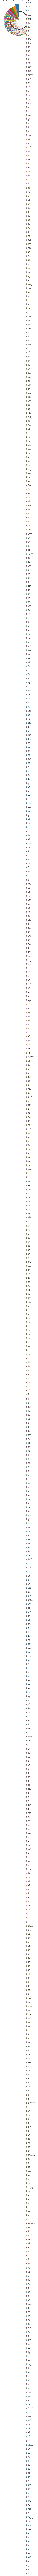

In [14]:
fig, ax1 = plt.subplots(figsize = (24,12)) 
explode = np.zeros(len(sumedSept['cases']))
explode[sumedSept['cases'].argmax()] = 0.1
ax1.pie(sumedSept['cases'], explode = explode, startangle=90, autopct='%1.0f%%', shadow = True) 
plt.title("Top Counties with the most covid cases- September", fontsize = 24) 
ax1.legend(sumedSept["county"], loc = "upper right") 
plt.show()

In [15]:
top10Biggest = sumedSept.head(10)
top10Smallest = sumedSept.tail(10)

In [17]:
countyMostCases_2months

,date,county,state,fips,cases,deaths
0,2020-09-01,Los Angeles,California,6037.0,242521,5829
1,2020-09-02,Los Angeles,California,6037.0,243935,5878
2,2020-09-03,Los Angeles,California,6037.0,244999,5932
3,2020-09-04,Los Angeles,California,6037.0,246407,5977
4,2020-09-05,Los Angeles,California,6037.0,247542,6000
...,...,...,...,...,...,...
26,2020-10-27,Los Angeles,California,6037.0,302077,7027
27,2020-10-28,Los Angeles,California,6037.0,303369,7040
28,2020-10-29,Los Angeles,California,6037.0,305070,7044
29,2020-10-30,Los Angeles,California,6037.0,306327,7056


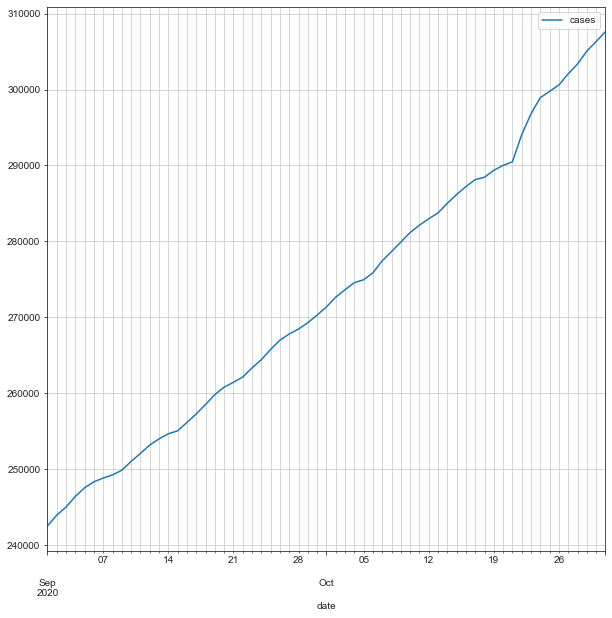

In [18]:
ax = countyMostCases_2months.plot(x = 'date', y = 'cases', figsize=(10,10))
xtick = pd.date_range( start=countyMostCases_2months.date.min( ), end=countyMostCases_2months.date.max( ), freq='D' )
ax.set_xticks( xtick, minor=True )
ax.grid('on', which='minor', axis='x')
ax.grid('on', which='major', axis='x')
ax.grid('on', which='major', axis='y')

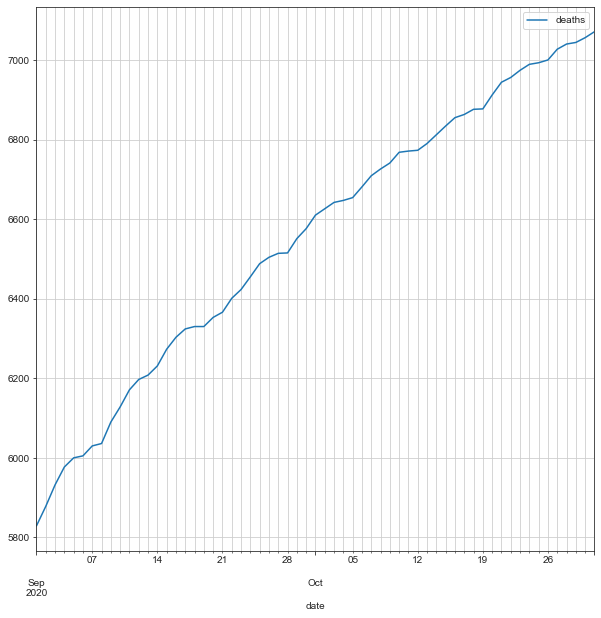

In [19]:
ax = countyMostCases_2months.plot(x = 'date', y = 'deaths', figsize=(10,10))
xtick = pd.date_range( start=countyMostCases_2months.date.min( ), end=countyMostCases_2months.date.max( ), freq='D' )
ax.set_xticks( xtick, minor=True )
ax.grid('on', which='minor', axis='x')
ax.grid('on', which='major', axis='x')
ax.grid('on', which='major', axis='y')

In [20]:
comparedData = compareSumedCovidDataByCounty(sumedSept, sumedOct)

In [21]:
comparedData

,county,state,fips_x,cases_x,deaths_x,fips_y,cases_y,deaths_y,increase
669,Marathon,Wisconsin,55073.0,1653,15,55073.0,5726,61,246.400484
892,Ward,North Dakota,38101.0,1123,11,38101.0,3422,54,204.719501
861,Flathead,Montana,30029.0,1176,19,30029.0,3492,27,196.938776
594,Sheboygan,Wisconsin,55117.0,1881,18,55117.0,5342,32,183.997873
799,Manitowoc,Wisconsin,55071.0,1284,4,55071.0,3347,19,160.669782
...,...,...,...,...,...,...,...,...,...
855,Accomack,Virginia,51001.0,1182,19,51001.0,1223,19,3.468697
640,East Feliciana,Louisiana,22037.0,1742,72,22037.0,1799,78,3.272101
975,Kleberg,Texas,48273.0,1003,44,48273.0,1033,52,2.991027
615,Bee,Texas,48025.0,1817,34,48025.0,1865,39,2.641717


In [22]:
top10 = comparedData.head(10)
bottom10 = comparedData.tail(10)

In [23]:
top10

,county,state,fips_x,cases_x,deaths_x,fips_y,cases_y,deaths_y,increase
669,Marathon,Wisconsin,55073.0,1653,15,55073.0,5726,61,246.400484
892,Ward,North Dakota,38101.0,1123,11,38101.0,3422,54,204.719501
861,Flathead,Montana,30029.0,1176,19,30029.0,3492,27,196.938776
594,Sheboygan,Wisconsin,55117.0,1881,18,55117.0,5342,32,183.997873
799,Manitowoc,Wisconsin,55071.0,1284,4,55071.0,3347,19,160.669782
961,Shawano,Wisconsin,55115.0,1020,1,55115.0,2654,27,160.196078
563,Dodge,Wisconsin,55027.0,1994,17,55027.0,4869,36,144.182548
723,Gallatin,Montana,30031.0,1473,4,30031.0,3445,9,133.876443
814,Waupaca,Wisconsin,55135.0,1240,21,55135.0,2867,55,131.209677
963,Oconto,Wisconsin,55083.0,1019,4,55083.0,2341,21,129.735034


In [24]:
bottom10

,county,state,fips_x,cases_x,deaths_x,fips_y,cases_y,deaths_y,increase
549,Vermilion,Louisiana,22113.0,2041,61,22113.0,2131,70,4.409603
688,St. John the Baptist,Louisiana,22095.0,1593,100,22095.0,1659,107,4.143126
56,Nueces,Texas,48355.0,20541,417,48355.0,21342,443,3.899518
818,Lafayette,Florida,12067.0,1233,12,12067.0,1279,16,3.730738
838,Willacy,Texas,48489.0,1204,50,48489.0,1247,56,3.571429
855,Accomack,Virginia,51001.0,1182,19,51001.0,1223,19,3.468697
640,East Feliciana,Louisiana,22037.0,1742,72,22037.0,1799,78,3.272101
975,Kleberg,Texas,48273.0,1003,44,48273.0,1033,52,2.991027
615,Bee,Texas,48025.0,1817,34,48025.0,1865,39,2.641717
515,Liberty,Texas,48291.0,2254,51,48291.0,2305,59,2.262644


In [25]:
votedTop = addVoteToCovidData(top10, election)
votedBottom = addVoteToCovidData(bottom10, election)
votetTopBiggest = addVoteToCovidData(top10Biggest, election)
votetTopSmallest = addVoteToCovidData(top10Smallest, election)

In [26]:
votedTop

,county,state,fips_x,cases_x,deaths_x,fips_y,cases_y,deaths_y,increase,DEM,REP,DEM_perc,REP_perc
669,Marathon,Wisconsin,55073.0,1653,15,55073.0,5726,61,246.400484,30808.0,44624.0,40.842083,59.157917
892,Ward,North Dakota,38101.0,1123,11,38101.0,3422,54,204.719501,7293.0,19974.0,26.746617,73.253383
861,Flathead,Montana,30029.0,1176,19,30029.0,3492,27,196.938776,20274.0,38321.0,34.600222,65.399778
594,Sheboygan,Wisconsin,55117.0,1881,18,55117.0,5342,32,183.997873,27101.0,37609.0,41.880699,58.119301
799,Manitowoc,Wisconsin,55071.0,1284,4,55071.0,3347,19,160.669782,16818.0,27218.0,38.191480,61.808520
961,Shawano,Wisconsin,55115.0,1020,1,55115.0,2654,27,160.196078,7131.0,15173.0,31.971844,68.028156
563,Dodge,Wisconsin,55027.0,1994,17,55027.0,4869,36,144.182548,16356.0,31355.0,34.281403,65.718597
723,Gallatin,Montana,30031.0,1473,4,30031.0,3445,9,133.876443,37044.0,31696.0,53.890020,46.109980
814,Waupaca,Wisconsin,55135.0,1240,21,55135.0,2867,55,131.209677,9703.0,18952.0,33.861455,66.138545
963,Oconto,Wisconsin,55083.0,1019,4,55083.0,2341,21,129.735034,6715.0,16226.0,29.270738,70.729262


In [27]:
votedBottom

,county,state,fips_x,cases_x,deaths_x,fips_y,cases_y,deaths_y,increase,DEM,REP,DEM_perc,REP_perc
549,Vermilion,Louisiana,22113.0,2041,61,22113.0,2131,70,4.409603,0.0,0.0,0.000000,0.000000
688,St. John the Baptist,Louisiana,22095.0,1593,100,22095.0,1659,107,4.143126,0.0,0.0,0.000000,0.000000
56,Nueces,Texas,48355.0,20541,417,48355.0,21342,443,3.899518,60749.0,64467.0,48.515365,51.484635
818,Lafayette,Florida,12067.0,1233,12,12067.0,1279,16,3.730738,509.0,3128.0,13.995051,86.004949
838,Willacy,Texas,48489.0,1204,50,48489.0,1247,56,3.571429,3097.0,2437.0,55.963137,44.036863
855,Accomack,Virginia,51001.0,1182,19,51001.0,1223,19,3.468697,7578.0,9172.0,45.241791,54.758209
640,East Feliciana,Louisiana,22037.0,1742,72,22037.0,1799,78,3.272101,0.0,0.0,0.000000,0.000000
975,Kleberg,Texas,48273.0,1003,44,48273.0,1033,52,2.991027,5359.0,5557.0,49.093074,50.906926
615,Bee,Texas,48025.0,1817,34,48025.0,1865,39,2.641717,3280.0,5999.0,35.348637,64.651363
515,Liberty,Texas,48291.0,2254,51,48291.0,2305,59,2.262644,5779.0,23288.0,19.881653,80.118347


In [28]:
votetTopBiggest

,county,state,fips,cases,deaths,DEM,REP,DEM_perc,REP_perc
0,Los Angeles,California,6037.0,270299,6576,2980478.0,1121538.0,72.658858,27.341142
1,New York City,New York,NaN,248738,23823,0.0,0.0,0.000000,0.000000
2,Miami-Dade,Florida,12086.0,170399,3280,617647.0,532734.0,53.690647,46.309353
3,Cook,Illinois,17031.0,145462,5225,1682455.0,546789.0,75.471999,24.528001
4,Harris,Texas,48201.0,142681,2599,911974.0,699822.0,56.581230,43.418770
5,Maricopa,Arizona,4013.0,141856,3395,1040774.0,995665.0,51.107546,48.892454
6,Dallas,Texas,48113.0,86500,1133,598576.0,307076.0,66.093378,33.906622
7,Broward,Florida,12011.0,77220,1396,618597.0,333346.0,64.982567,35.017433
8,Clark,Nevada,32003.0,67176,1391,493799.0,402329.0,55.103624,44.896376
9,Riverside,California,6065.0,59405,1226,442164.0,372130.0,54.300290,45.699710


In [29]:
votetTopSmallest

,county,state,fips,cases,deaths,DEM,REP,DEM_perc,REP_perc
3230,Harding,New Mexico,35021.0,2,0,179.0,319.0,35.943775,64.056225
3231,Banner,Nebraska,31007.0,2,0,43.0,362.0,10.617284,89.382716
3232,Blaine,Nebraska,31009.0,1,0,35.0,280.0,11.111111,88.888889
3234,Grant,Nebraska,31075.0,1,0,20.0,375.0,5.063291,94.936709
3235,De Baca,New Mexico,35011.0,1,0,231.0,656.0,26.042841,73.957159
3236,Wheeler,Nebraska,31183.0,1,0,59.0,438.0,11.871227,88.128773
3237,Borden,Texas,48033.0,1,0,16.0,395.0,3.892944,96.107056
3238,Arthur,Nebraska,31005.0,1,0,21.0,260.0,7.473310,92.526690
3239,Daggett,Utah,49009.0,1,0,105.0,473.0,18.166090,81.833910
3240,Kiowa,Colorado,8061.0,1,0,98.0,795.0,10.974244,89.025756


In [30]:
top10States = votedTop.state.unique()

In [31]:
for state in top10States:
    covidTemp = getCovidDataByState(comparedData, state)
    print(addVoteToCovidData(covidTemp, election))

         county      state   fips_x  cases_x  deaths_x   fips_y  cases_y  \
0      Marathon  Wisconsin  55073.0     1653        15  55073.0     5726   
1     Sheboygan  Wisconsin  55117.0     1881        18  55117.0     5342   
2     Manitowoc  Wisconsin  55071.0     1284         4  55071.0     3347   
3       Shawano  Wisconsin  55115.0     1020         1  55115.0     2654   
4         Dodge  Wisconsin  55027.0     1994        17  55027.0     4869   
5       Waupaca  Wisconsin  55135.0     1240        21  55135.0     2867   
6        Oconto  Wisconsin  55083.0     1019         4  55083.0     2341   
7     Winnebago  Wisconsin  55139.0     4292        28  55139.0     9803   
8   Fond du Lac  Wisconsin  55039.0     2276        14  55039.0     5151   
9       Calumet  Wisconsin  55015.0     1325         5  55015.0     2886   
10    St. Croix  Wisconsin  55109.0     1024         9  55109.0     2155   
11         Rock  Wisconsin  55105.0     2822        32  55105.0     5796   
12         S

In [32]:
Wisconsin = getCovidDataByState(comparedData, 'Wisconsin')
Wisconsin = addVoteToCovidData(Wisconsin, election)


In [33]:
Demwining = []
for dem, rep in zip(Wisconsin.DEM_perc, Wisconsin.REP_perc):
    if dem > rep:
        Demwining.append(1)
    else:
        Demwining.append(0)

In [34]:
Wisconsin['DEMWining'] = Demwining

In [35]:
Wisconsin

,county,state,fips_x,cases_x,deaths_x,fips_y,cases_y,deaths_y,increase,DEM,REP,DEM_perc,REP_perc,DEMWining
0,Marathon,Wisconsin,55073.0,1653,15,55073.0,5726,61,246.400484,30808.0,44624.0,40.842083,59.157917,0
1,Sheboygan,Wisconsin,55117.0,1881,18,55117.0,5342,32,183.997873,27101.0,37609.0,41.880699,58.119301,0
2,Manitowoc,Wisconsin,55071.0,1284,4,55071.0,3347,19,160.669782,16818.0,27218.0,38.191480,61.808520,0
3,Shawano,Wisconsin,55115.0,1020,1,55115.0,2654,27,160.196078,7131.0,15173.0,31.971844,68.028156,0
4,Dodge,Wisconsin,55027.0,1994,17,55027.0,4869,36,144.182548,16356.0,31355.0,34.281403,65.718597,0
5,Waupaca,Wisconsin,55135.0,1240,21,55135.0,2867,55,131.209677,9703.0,18952.0,33.861455,66.138545,0
6,Oconto,Wisconsin,55083.0,1019,4,55083.0,2341,21,129.735034,6715.0,16226.0,29.270738,70.729262,0
7,Winnebago,Wisconsin,55139.0,4292,28,55139.0,9803,69,128.401678,44060.0,47796.0,47.966382,52.033618,0
8,Fond du Lac,Wisconsin,55039.0,2276,14,55039.0,5151,23,126.318102,20588.0,35754.0,36.541124,63.458876,0
9,Calumet,Wisconsin,55015.0,1325,5,55015.0,2886,14,117.811321,12116.0,18156.0,40.023784,59.976216,0


# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

<p style="color:Dark blue;line-height:1.3em;font-size:1.3em;">
We collected the election data and COVID data, we will plot and then visualize if there is any correlation.</p><br>




















Write codes to implement the solution in python:

In [36]:
#draw map from percent increase of covid cases
drawMap(comparedData,'fips_x','increase','percent increase', './dplot1.html',max_value = 100,min_value = 0)

In [37]:
IFrame(src='./dplot1.html', width=1000, height=800)

In [38]:
election_result = addVoteToCovidData(sumedSept, election)
DEMwining = []
for dem, rep in zip(election_result.DEM_perc, election_result.REP_perc):
    if dem > rep:
        DEMwining.append(1)
    else:
        DEMwining.append(0)
election_result['DEMwining'] = DEMwining
#election_result.head(10)

C:\Users\nithi\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in longlong_scalars



In [39]:
election_result = election_result.drop([1]) #drop New York City
election_result.head(10)

,county,state,fips,cases,deaths,DEM,REP,DEM_perc,REP_perc,DEMwining
0,Los Angeles,California,6037.0,270299,6576,2980478.0,1121538.0,72.658858,27.341142,1
2,Miami-Dade,Florida,12086.0,170399,3280,617647.0,532734.0,53.690647,46.309353,1
3,Cook,Illinois,17031.0,145462,5225,1682455.0,546789.0,75.471999,24.528001,1
4,Harris,Texas,48201.0,142681,2599,911974.0,699822.0,56.581230,43.418770,1
5,Maricopa,Arizona,4013.0,141856,3395,1040774.0,995665.0,51.107546,48.892454,1
6,Dallas,Texas,48113.0,86500,1133,598576.0,307076.0,66.093378,33.906622,1
7,Broward,Florida,12011.0,77220,1396,618597.0,333346.0,64.982567,35.017433,1
8,Clark,Nevada,32003.0,67176,1391,493799.0,402329.0,55.103624,44.896376,1
9,Riverside,California,6065.0,59405,1226,442164.0,372130.0,54.300290,45.699710,1
10,Bexar,Texas,48029.0,57844,1313,440823.0,303871.0,59.195186,40.804814,1


# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


<p style="color:Dark blue;line-height:1.3em;font-size:1.3em;">
The data shows that there is no strong correlation between election and COVID-19.</p><br>







In [40]:
drawMap(election_result,'fips','DEMwining','DEM (Blue) vs REP (Red)', './dplot2.html',max_value = 1,min_value = 0, color_scale = 'Bluered_r')

In [41]:
IFrame(src='./dplot2.html', width=1000, height=800)


# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


**How to submit:**

        Please submit through Canvas, in the Assignment "Case Study 4".
        
**Note: Each team only needs to submit one submission in Canvas**